In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import os

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model import GPTMatchingModel
from metrics import MatchingMetrics
from utils import CheckpointManager
from minGPT.mingpt.bpe import BPETokenizer
from evaluate import evaluate_jd_cv_pairs

/home/marwan/anaconda3/envs/Edwin/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda'  
model_name = 'gpt2_b1024_l12_h12_e768_nowd_lt0.4_ht0.75' 
#model_name = 'v0/gpt2_b1024_l12_h12_e768_slightbalancedataset'

In [3]:
# Load model
model_path = os.path.join('checkpoints', model_name)
checkpoint_path = os.path.join(model_path, 'best.pt')
checkpoint = torch.load(checkpoint_path, map_location=device)
model_config = checkpoint['model_config']

model_config.model_type = None
model = GPTMatchingModel(model_config)
checkpoint_manager = CheckpointManager(model_path, model_config=model_config)
checkpoint = checkpoint_manager.load_checkpoint(model, checkpoint_path=checkpoint_path, map_location=device)
model = model.to(device)

try:
    sep_token = model.config.sep_token
    pad_token_id = model.config.pad_token_id
    thresholds = model.config.thresholds
    label_map=model.config.label_map
except AttributeError:
    sep_token = '###'
    pad_token_id = 0
    thresholds = [0.4, 0.75]
    label_map={
            'No Fit': 0.0,
            'Potential Fit': 0.6,
            'Good Fit': 1.0
        }


tokenizer = BPETokenizer()

# Initialize metrics calculator
metrics_calculator = MatchingMetrics(label_map=label_map, thresholds=thresholds)

# Load original data
data = pd.read_csv('data/test.csv')


/tmp/ipykernel_508193/2644403147.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


number of parameters: 124.44M
Loading checkpoint from checkpoints/gpt2_b1024_l12_h12_e768_nowd_lt0.4_ht0.75/best.pt


/home/marwan/Edwin/utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)


In [4]:

# Evaluate
print("\nEvaluating model...")
metrics, scores, labels, _ = evaluate_jd_cv_pairs(
    model=model,
    data=data,
    tokenizer=tokenizer,
    block_size=model.config.block_size,
    device=device,
    metrics_calculator=metrics_calculator,
    verbose=False
)

# Print and save results
print("\nEvaluation Results:")
metrics_calculator.print_metrics(metrics)


# Save metrics

print(f"Model: {model_name}\n\n")
print("Evaluation Results:\n")
print(f"Accuracy: {metrics['accuracy']:.4f}\n")
print(f"MSE: {metrics['mse']:.4f}\n")
print(f"RMSE: {metrics['rmse']:.4f}\n\n")
print(f"Weighted F1: {metrics['f1_weighted']:.4f}")

print("Per-Class Metrics:\n")
for class_name, class_metrics in metrics['per_class'].items():
    print(f"\n{class_name}:\n")
    for metric_name, value in class_metrics.items():
        print(f"  {metric_name}: {value:.4f}\n")

# Save predictions
data['predicted_score'] = scores
data['true_label'] = labels


Evaluating model...

Evaluation Results:

=== Classification Metrics ===
Overall Accuracy: 0.4429
MSE: 0.1697
RMSE: 0.4120

Weighted F1: 0.4404
=== Per-Class Metrics ===

No Fit:
  Precision: 0.6611
  Recall: 0.5099
  F1-Score: 0.5758

Potential Fit:
  Precision: 0.2818
  Recall: 0.6081
  F1-Score: 0.3852

Good Fit:
  Precision: 0.5143
  Recall: 0.1572
  F1-Score: 0.2408

=== Confusion Matrix ===
Rows: True Labels, Columns: Predicted Labels
Labels order: No Fit (0), Potential Fit (1), Good Fit (2)
[[437 374  46]
 [152 270  22]
 [ 72 314  72]]
Model: gpt2_b1024_l12_h12_e768_nowd_lt0.4_ht0.75


Evaluation Results:

Accuracy: 0.4429

MSE: 0.1697

RMSE: 0.4120


Weighted F1: 0.4404
Per-Class Metrics:


No Fit:

  precision: 0.6611

  recall: 0.5099

  f1: 0.5758


Potential Fit:

  precision: 0.2818

  recall: 0.6081

  f1: 0.3852


Good Fit:

  precision: 0.5143

  recall: 0.1572

  f1: 0.2408



In [5]:
def plot_score_distribution(all_scores, all_labels, label_map):
    """
    Create histograms of scores for each class with modified visualization
    
    Parameters:
    - all_scores: List of model prediction scores
    - all_labels: Corresponding true labels
    - label_map: Dictionary mapping label names to numeric values
    """
    # Reverse the label map to get label names
    label_names = {v: k for k, v in label_map.items()}
    
    # Create more granular buckets
    buckets = np.linspace(0, 1, 21)  # 0 to 1 with 20 intervals
    
    # Color map
    colors = {
        0.0: 'red',    # No Fit
        0.6: 'orange', # Potential Fit
        1.0: 'green'   # Good Fit
    }
    
    # Create a figure with horizontal layout
    plt.figure(figsize=(15, 5))
    
    # Iterate through unique labels
    unique_labels = sorted(set(all_labels))
    
    for i, label in enumerate(unique_labels, 1):
        # Filter scores for this specific label
        label_scores = [score for score, true_label in zip(all_scores, all_labels) if true_label == label]
        
        # Create subplot
        plt.subplot(1, len(unique_labels), i)
        
        # Create histogram with specified color
        plt.hist(label_scores, 
                 bins=buckets, 
                 edgecolor='black', 
                 color=colors[label],
                 alpha=0.7)
        
        # Customize plot
        plt.title(f'{label_names[label]} Scores', fontsize=12)
        plt.xlabel('Score', fontsize=10)
        plt.ylabel('Number of Samples', fontsize=10)
        plt.xlim(0, 1)
        
        # Add grid for readability
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Add additional information
        plt.text(0.05, 0.95, f'Total Samples: {len(label_scores)}', 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

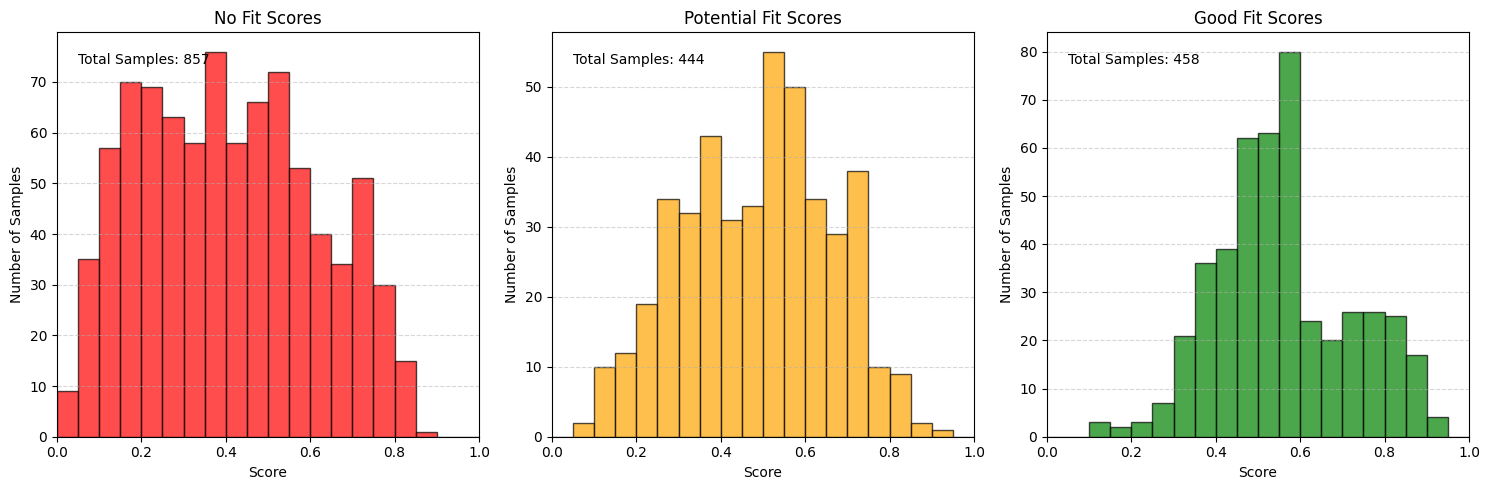

In [6]:
# gpt2_b1024_l12_h12_e768_nowd_lt0.4_ht0.75
plot_score_distribution(scores, labels, label_map)

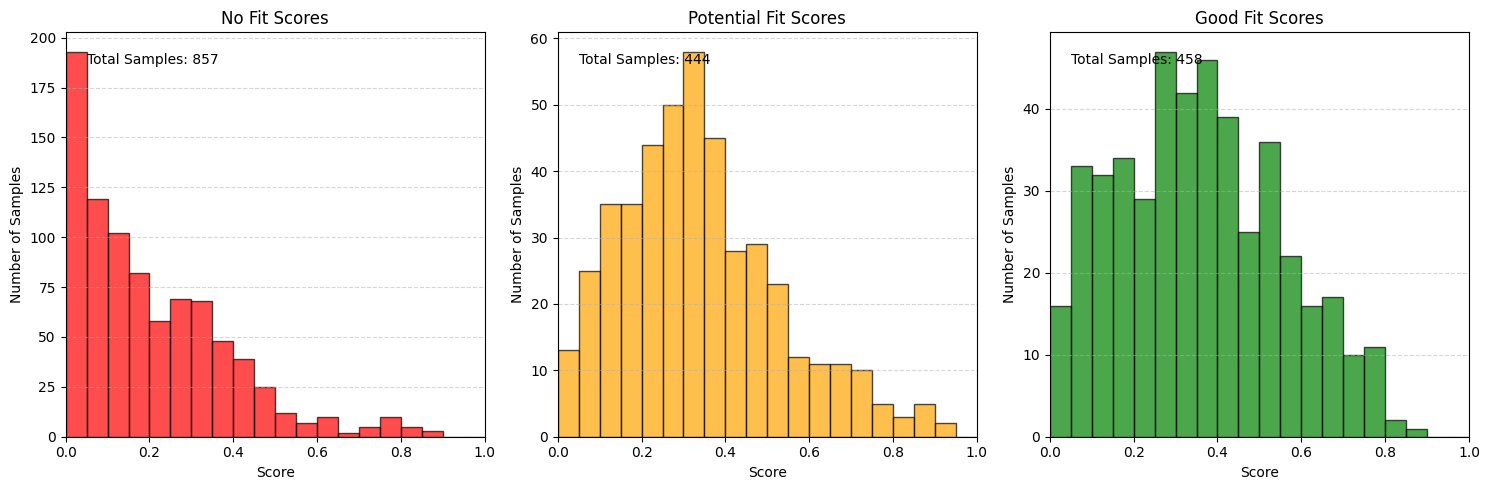

In [ ]:
# v0/gpt2_b1024_l12_h12_e768_slightbalancedataset
plot_score_distribution(scores, labels, label_map)